##1.0 DATA UNDERSTANDING

In [ ]:
# Import Required Packages
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import string
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import logging
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from sklearn.utils import resample
import seaborn as sns
import nltk
from nltk.corpus import stopwords


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json

# Specify the path to the JSON file in Google Drive
# Specify the path to the JSON file in Google Drive
json_file_path = '/content/drive/MyDrive/tweets_ws23_v1.json'

redit_file_path = '/content/drive/MyDrive/sarcasm_detector/train-balanced-sarcasm.csv'

# Load the JSON data
with open(json_file_path, 'r') as file:
    df = json.load(file)



In [ ]:


# Load the JSON/csv files into a DataFrame
tweet_df = pd.json_normalize(df)
reddit_df = pd.read_csv(redit_file_path)

# Display the first few rows of the Tweet DataFrame
print( "first few rows of Tweet Dataset: ", tweet_df.head())
print("Shape of the normarlised Tweet Dataset: ", tweet_df.shape)


first few rows of Tweet Dataset:              source_created_at           author_id  \
0  2020-09-18 21:56:20.798000           593731316   
1  2020-10-13 07:31:53.122000  745583289520496640   
2  2020-10-26 19:27:24.695000           303134761   
3  2020-10-26 19:28:49.281000           303134761   
4  2020-09-28 11:59:41.212000            56427671   

                                                text    source language  \
0  @DSisourath The Thameslink core between London...  sprinklr       en   
1  @DulwichHistory Loving the complaint about peo...  sprinklr       en   
2  @SW_Help .And yet you have no toilets on some ...  sprinklr       en   
3  @SW_Help you have no toilets on some of your t...  sprinklr       en   
4  @SpeedySticks007 @MrNeilJH @TLRailUK @christia...  sprinklr       en   

   longitude  latitude                                    id  \
0   -0.12574  51.50853  acd7673f-e621-5f1a-d662-df278964a6ea   
1   -0.12574  51.50853  5b92aba8-4b05-6c63-8485-e9c870742137   
2   

In [ ]:
# Display the shape and first few rows of the Reddit DataFrame

print("Shape of the normarlised Reddit Dataset: ", reddit_df.shape)

print( "first few rows of Reddit Dataset: ", reddit_df.head())


Shape of the normarlised Reddit Dataset:  (1010826, 10)
first few rows of Reddit Dataset:     label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                   

In [ ]:
print(reddit_df.columns)

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')


In [ ]:
# Calculate lengths
reddit_df['comment_length'] = reddit_df['comment'].astype(str).apply(len)

# Get max, min, and average tweet length
max_length = reddit_df['comment_length'].max()
min_length = reddit_df['comment_length'].min()
average_length = reddit_df['comment_length'].mean()

print("Maximum tweet length:", max_length)
print("Minimum tweet length:", min_length)
print("Average tweet length:", average_length)

Maximum tweet length: 10000
Minimum tweet length: 1
Average tweet length: 56.68948167142515


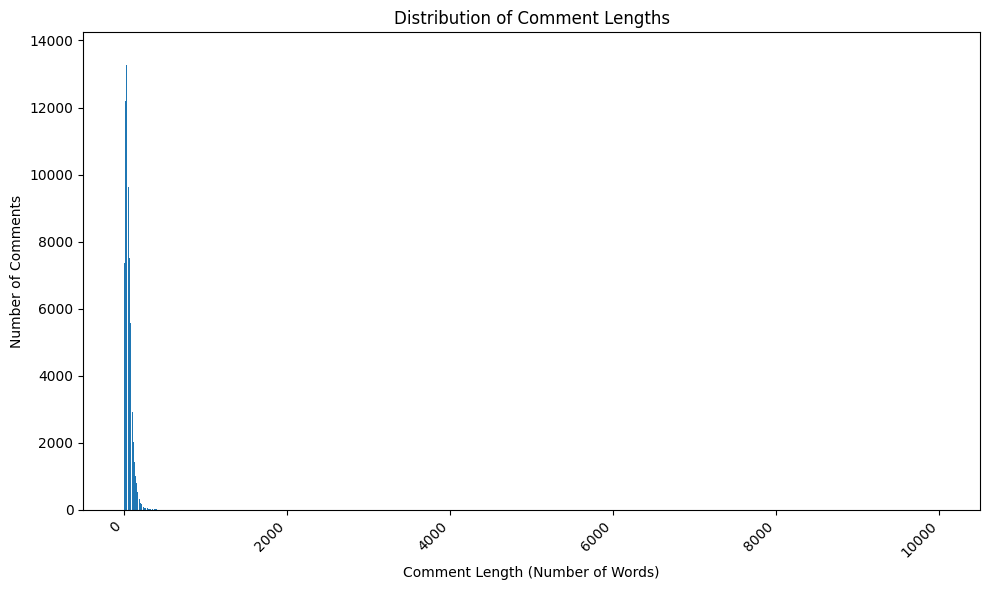

In [ ]:
# Assuming you have already calculated 'comment_length'
reddit_df['comment_length'] = reddit_df['comment'].astype(str).apply(len)

# Group by comment length and count occurrences
comment_length_counts = reddit_df.groupby('comment_length')['comment'].count().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(comment_length_counts['comment_length'], comment_length_counts['comment'])
plt.xlabel('Comment Length (Number of Words)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
print(tweet_df.shape)
print(tweet_df.columns)
#print(tweet_df['text'].head())

(16949, 11)
Index(['source_created_at', 'author_id', 'text', 'source', 'language',
       'longitude', 'latitude', 'id', 'labels.topic', 'labels.sentiment',
       'source_id'],
      dtype='object')


In [ ]:
# Strange characters in the Comments


# Combine all text into one string
all_text_reddit = ''.join(reddit_df['comment'].astype(str))

# Get unique non-alphabetic characters
non_alpha_characters_reddit = {char for char in set(all_text_reddit) if not char.isalpha()}

print(non_alpha_characters_reddit)

{':', '6', '`', '5', '-', ']', ',', '~', '[', '4', '3', '\x08', '+', '.', '*', '>', '%', '/', '@', '#', '^', ' ', '\\', '2', '|', '?', '&', '9', '0', '_', '$', ')', '7', '1', '8', '{', ';', '=', '(', '}', '"', "'", '!'}


In [ ]:
# Strange characters in the Comments/tweets


# Combine all text into one string
all_text_tweet = ''.join(tweet_df['text'])

# Get unique non-alphabetic characters
non_alpha_characters_tweet = {char for char in set(all_text_tweet) if not char.isalpha()}

print(non_alpha_characters_tweet)

{'⏱', '4', '🙌', '🏾', '☎', '🌞', '🌟', '\U000e006e', '🌳', '😖', '🩺', '🖥', '👏', '📱', '🔥', '☀', '‘', '1', '☔', '😋', '😁', '🏉', '🎄', '`', '•', '”', '♿', '👆', '🤚', '😐', ')', '🎫', '📣', '😾', '😎', '⏰', '💁', '🥔', '£', '5', '\U000e007f', '\u3000', '@', '🌹', '🤧', '🤰', '🍍', '⚓', '📡', '⚠', '✌', '🚃', '😀', '☺', '🤔', '😥', '😣', '😒', '💩', '😃', '🤮', '⁉', '♀', '🥶', '🤷', '🙅', '🙉', '😂', '👷', '€', '🗺', '😏', '🛤', '🛠', '🍩', ';', '💤', '🥰', "'", '🤡', '💷', ':', '🚻', '📢', '♂', '-', '[', '»', '😙', '🙄', '🚦', '🙁', '🚲', '📴', '💙', '⚡', '🚄', '7', '😛', '🤯', '📲', '🚉', '🏡', '☁', '🖕', '😊', '👤', '.', '\u2066', '🏆', '🚌', '🖌', '💚', '🍁', '$', '8', '🍆', '😦', '😫', '🧼', '📊', '%', '😌', '🚴', '👀', '🥴', '☹', '👊', '&', '😶', '🤬', '✅', '´', '😨', '🕯', '¾', '😕', '😱', '6', '3', '🚊', '/', '😤', '👉', '🤢', '😝', '😜', '🥳', '0', '🤪', '🐶', '➡', '–', '<', '🆕', '☕', '😓', '❤', '😡', '👋', '💦', '💨', '*', '>', '😴', '🐌', '🌍', '🚩', '🛑', '🌩', '=', '(', '💖', '"', '🧐', '🚍', '🏴', ',', '🍐', '🤓', '😬', '🥂', '🕐', '❄', '🚆', '#', '🌧', '👍', '🐾', '🔁', '\u2069', '🙊', '📈', '

## 2.0 DATA PREPARATION

In [ ]:
# Configuration
MODEL_PATH = "jkhan447/sarcasm-detection-Bert-base-uncased-newdata" # Import hugginface model model="jkhan447/sarcasm-detection-Bert-base-uncased-newdata"
BATCH_SIZE = 16
MAX_LENGTH = 256
EPOCHS = 3
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define preprocessing
def preprocess_data(text: str) -> str:
    # Remove everything except alphabetic characters and spaces
    return ''.join([char.lower() for char in text if char.isalpha() or char.isspace()]).strip()


In [ ]:
# Define Custom Dataset Class for mreprocessing
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = preprocess_data(self.texts[idx])
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}



In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2)
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Load and balance dataset
samples_per_class = 10000 // reddit_df['label'].nunique()
balanced_reddit_df = pd.concat([
    resample(reddit_df[reddit_df['label'] == label],
             replace=False,
             n_samples=samples_per_class,
             random_state=42)
    for label in reddit_df['label'].unique()
])

# Split Data into train and test data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_reddit_df['comment'].astype(str), balanced_reddit_df['label'], test_size=0.2, random_state=42
)

In [ ]:
train_dataset = SarcasmDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, MAX_LENGTH)
test_dataset = SarcasmDataset(test_texts.tolist(), test_labels.tolist(), tokenizer, MAX_LENGTH)


#### 2.2 Preprocess tweet datasets

## 3.0 Modelling

In [ ]:

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./sarcasm_detector_results",   # Directory to save model checkpoints and logs
    evaluation_strategy="epoch",               # Evaluate at each epoch
    learning_rate=LEARNING_RATE,               # Learning rate
    per_device_train_batch_size=BATCH_SIZE,    # Batch size for training
    per_device_eval_batch_size=BATCH_SIZE,     # Batch size for evaluation
    num_train_epochs=EPOCHS,                   # Number of training epochs
    weight_decay=0.01,                         # Weight decay for regularization
    logging_dir="./logs",                      # Directory for logs
    save_strategy="epoch",                     # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,               # Load the best model at the end of training
    metric_for_best_model="accuracy",          # Use accuracy to select the best model
    report_to="none"                           # Disable logging to external services (e.g., WandB)
)

# Define compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Training and evaluation
trainer.train()

# Get training metrics
history = trainer.state.log_history


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.406900,0.381343,0.830500,0.825528,0.839791,0.811741
2,0.213100,0.515858,0.825500,0.827313,0.809293,0.846154
3,0.112500,0.729365,0.822500,0.822943,0.811209,0.835020


In [ ]:
# Save the trained model and tokenizer
model.save_pretrained("/content/drive/MyDrive/sac_model_output")
tokenizer.save_pretrained("/content/drive/MyDrive/sac_model_output")

('/content/drive/MyDrive/sac_model_output/tokenizer_config.json',
 '/content/drive/MyDrive/sac_model_output/special_tokens_map.json',
 '/content/drive/MyDrive/sac_model_output/vocab.txt',
 '/content/drive/MyDrive/sac_model_output/added_tokens.json',
 '/content/drive/MyDrive/sac_model_output/tokenizer.json')

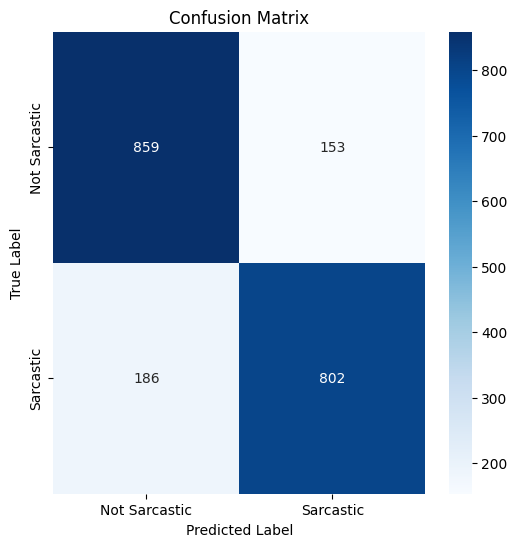

In [ ]:
# Evaluate on test set and display confusion matrix
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

conf_matrix = confusion_matrix(test_labels, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(history)

[{'loss': 0.4069, 'grad_norm': 10.235968589782715, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0, 'step': 500}, {'eval_loss': 0.3813434839248657, 'eval_accuracy': 0.8305, 'eval_f1': 0.8255275347400927, 'eval_precision': 0.8397905759162304, 'eval_recall': 0.8117408906882592, 'eval_runtime': 28.5798, 'eval_samples_per_second': 69.98, 'eval_steps_per_second': 4.374, 'epoch': 1.0, 'step': 500}, {'loss': 0.2131, 'grad_norm': 31.21587371826172, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0, 'step': 1000}, {'eval_loss': 0.5158575177192688, 'eval_accuracy': 0.8255, 'eval_f1': 0.8273132112815438, 'eval_precision': 0.8092933204259438, 'eval_recall': 0.8461538461538461, 'eval_runtime': 27.4893, 'eval_samples_per_second': 72.755, 'eval_steps_per_second': 4.547, 'epoch': 2.0, 'step': 1000}, {'loss': 0.1125, 'grad_norm': 3.7430877685546875, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 1500}, {'eval_loss': 0.7293645143508911, 'eval_accuracy': 0.8225, 'eval_f1': 0.8229426433915212, 'eval

### 3.2 Deploy to Interpretation model

In [ ]:
#Model path
model_path = "/content/drive/MyDrive/sac_model_output"
# Load the model and tokenizer from the saved directory
final_model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 256


# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.to(DEVICE)

# Preprocessing function (same as during training)
def preprocess_data(text: str) -> str:
    return ''.join([char.lower() for char in text if char.isalpha() or char.isspace()]).strip()

# Prediction function
def predict_text(text: str) -> dict:
    # Preprocess the input text
    text = preprocess_data(text)

    # Tokenize the input text
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt").to(DEVICE)

    # Make the prediction
    with torch.no_grad():
        output = model(**inputs)

    # Get logits and apply softmax to convert them to probabilities
    probs = output.logits.softmax(dim=-1).tolist()[0]

    # Get the predicted class and confidence score
    confidence = max(probs)
    predicted_class = torch.argmax(output.logits, dim=-1).item()

    # Map predicted_class to actual class name
    class_names = ["Not Sarcastic", "Sarcastic"]
    result = {
        "prediction": class_names[predicted_class],
        "confidence": confidence
    }

    return result

# Apply the prediction function to the 'text' column
def apply_predictions(df):
    # Apply the `predict_text` function to each row in the 'text' column
    predictions = df['text'].apply(lambda x: predict_text(x))

    # Extract prediction and confidence into separate columns
    df['prediction'] = predictions.apply(lambda x: x['prediction'])
    df['confidence'] = predictions.apply(lambda x: x['confidence'])

    return df






In [ ]:
# Example: Apply predictions to the DataFrame
tweet_prediction_df = apply_predictions(tweet_df)

In [ ]:
# Show the updated DataFrame
print(tweet_prediction_df.head())

# Saving the Predictions
tweet_prediction_df.to_csv("/content/drive/MyDrive/tweet_prediction_df.csv", index=False)

            source_created_at           author_id  \
0  2020-09-18 21:56:20.798000           593731316   
1  2020-10-13 07:31:53.122000  745583289520496640   
2  2020-10-26 19:27:24.695000           303134761   
3  2020-10-26 19:28:49.281000           303134761   
4  2020-09-28 11:59:41.212000            56427671   

                                                text    source language  \
0  @DSisourath The Thameslink core between London...  sprinklr       en   
1  @DulwichHistory Loving the complaint about peo...  sprinklr       en   
2  @SW_Help .And yet you have no toilets on some ...  sprinklr       en   
3  @SW_Help you have no toilets on some of your t...  sprinklr       en   
4  @SpeedySticks007 @MrNeilJH @TLRailUK @christia...  sprinklr       en   

   longitude  latitude                                    id  \
0   -0.12574  51.50853  acd7673f-e621-5f1a-d662-df278964a6ea   
1   -0.12574  51.50853  5b92aba8-4b05-6c63-8485-e9c870742137   
2   -0.12574  51.50853  0a799c07-8b76-

In [ ]:
# Create a new dataset for tweets and prediction

only_tweet_prediction_df=tweet_prediction_df[['text', 'prediction', 'confidence']]
print(only_tweet_prediction_df.head())

                                                text     prediction  \
0  @DSisourath The Thameslink core between London...  Not Sarcastic   
1  @DulwichHistory Loving the complaint about peo...      Sarcastic   
2  @SW_Help .And yet you have no toilets on some ...      Sarcastic   
3  @SW_Help you have no toilets on some of your t...      Sarcastic   
4  @SpeedySticks007 @MrNeilJH @TLRailUK @christia...  Not Sarcastic   

   confidence  
0    0.986602  
1    0.848991  
2    0.545836  
3    0.688500  
4    0.505856  


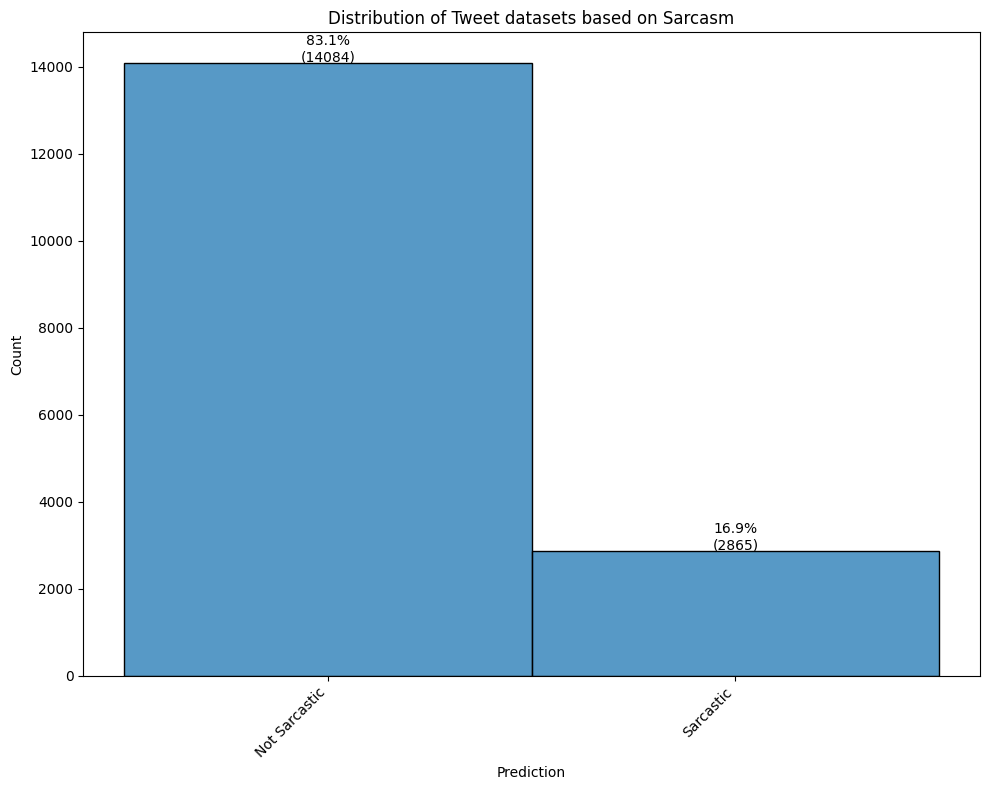

In [ ]:
# Create the histogram using seaborn
plt.figure(figsize=(10, 8))
ax = sns.histplot(only_tweet_prediction_df['prediction'], stat="count")

# Get total number of data points
total = len(only_tweet_prediction_df)

# Add percentage and count labels to bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    count = '{:d}'.format(p.get_height().astype(int))  # Convert to integer
    ax.annotate(f'{percentage}\n({count})', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Tweet datasets based on Sarcasm')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Create Only sarcastic tweets DF for further prediction

In [ ]:
only_sarcastic_tweet_df = tweet_prediction_df[tweet_prediction_df['prediction'] == 'Sarcastic']

In [ ]:
# Set display options to show all text content
pd.set_option("display.max_colwidth", None)


In [ ]:
# print 5 randomly sample sarcastic tweets
print(only_sarcastic_tweet_df[['text']].sample(5))

                                                                                                                                                                                                                                                                                    text
5653                                                                                                                                                                                         @TLRailUK Delays I get, but no communication, false information? That’s always the problem.
2068                                          1642 Thameslink train to Peterborough: On time - plat 1 1648 Thameslink train to London Kings Cross: expected 1654 - plat 4 1710 Thameslink train to Peterborough: Delayed - plat 1 1718 Thameslink train to London Kings Cross: Cancelled
10993                                                                                                                                                        

In [ ]:
# Saving Only sarcastic Df as csv
only_sarcastic_tweet_df.to_csv("/content/drive/MyDrive/only_sarcastic_tweet_df.csv", index=False)